In [1]:
from fastai.vision import *

In [2]:
data = Path("data/fruits-360/")

In [3]:
training_dir = (data/"Training")

In [4]:
testing_dir = (data/"Test")

In [5]:
data = (ImageImageList
        .from_folder(training_dir)
        .split_by_rand_pct(0.2)
        .label_from_func(lambda x: x)
        .transform(size=25)
        .databunch(bs=128)
       )

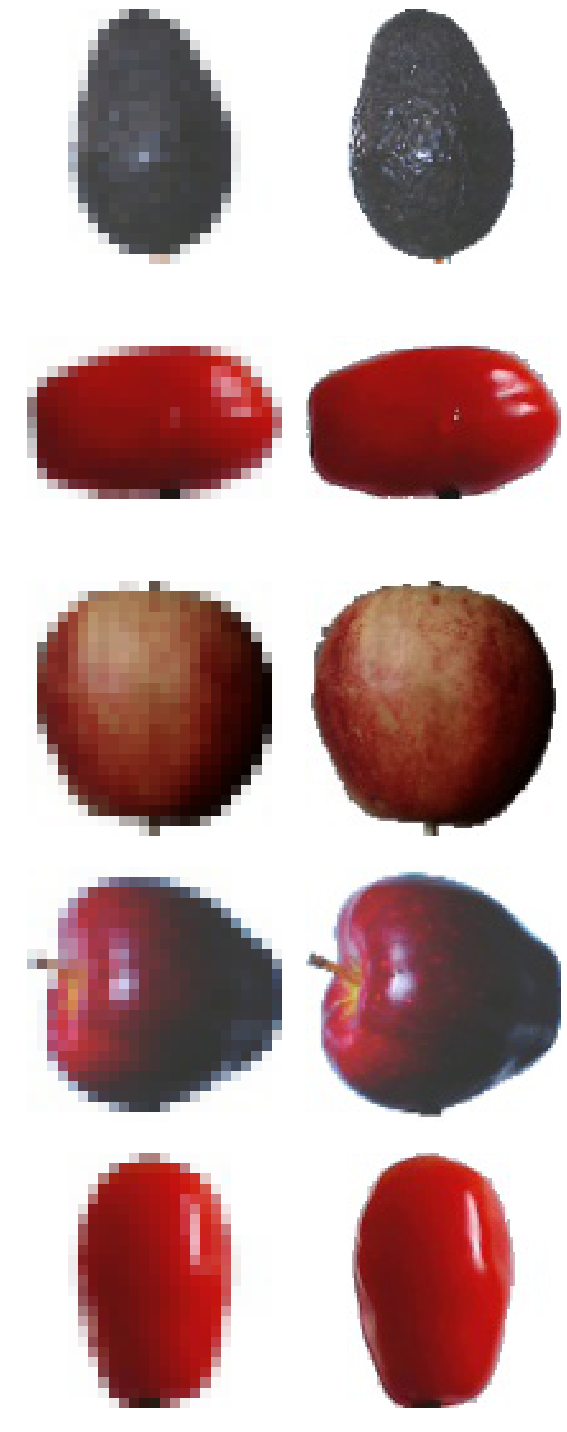

In [6]:
data.show_batch(5)

In [7]:
class SuperRes(nn.Module):
    def __init__(self):
        super().__init__()
        features = [nn.Conv2d(3, 64, 5, padding=5//2)]
        for i in range(4): features.append(res_block(64))
        for i in range(2): features.append(PixelShuffle_ICNR(64,64))
        features.append(nn.Conv2d(64, 3, 5, padding=5//2))
        self.features = nn.Sequential(*features)
        
    def forward(self, x):
        return self.features(x)

In [8]:
def superres(pretrained=False, **kwargs):
    """
    Creating an architecture for super resolution as defined in this paper: http://arxiv.org/abs/1603.08155
    Supporting Material: https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf
    
    This is a modification of the x4 architecture because this is designed to go from 25 px to 100 px 
    instead of 72 px to 288 px which is what is done in the paper
    """
    model = SuperRes()

    if pretrained:
        assert pretrained==False, "Pretrained not currently available" #Leaving this structure in place because this is where the pretrained weights would be placed
    return model

In [9]:
model = nn.DataParallel(superres().cuda())

In [10]:
m_vgg = models.vgg16_bn(pretrained=True)

In [11]:
blocks = [i-1 for i,j in list(enumerate(m_vgg.features.children())) if isinstance(j,nn.MaxPool2d)]

In [12]:
blocks, [list(m_vgg.features.children())[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [13]:
#Trusting Jeremy Here: 
vgg_layers = list(m_vgg.features.children())[:13]
m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
#Freeze Weights
for p in m_vgg.parameters(): p.requires_grad=False

In [14]:
def flatten(x): return x.view(x.size(0), -1)

In [15]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [16]:
class FeatureLoss(nn.Module):
    def __init__(self, m, layer_ids, layer_wgts):
        super().__init__()
        self.m, self.wgts = m, layer_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]
    
    def forward(self, input, target, sum_layers=True):
        self.m(target.data)
        res = [F.l1_loss(input, target)/100]
        targ_feat = [o.features.data.clone() for o in self.sfs]
        self.m(input)
        res+=[F.l1_loss(flatten(inp.features),flatten(targ))*wgt
              for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

In [17]:
cust_loss_func = FeatureLoss(m_vgg, blocks[:2], [0.26,0.74])

In [18]:
learn = Learner(data, model, opt_func=optim.Adam, loss_func=cust_loss_func)

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


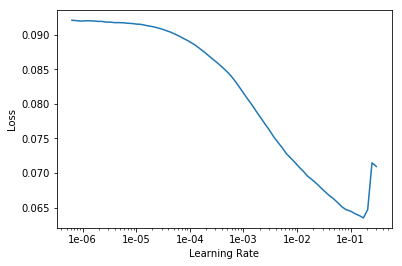

In [20]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(10, 2e-2)

epoch,train_loss,valid_loss,time
0,0.024135,0.025085,02:57
1,0.021123,0.021610,02:57
2,0.019591,0.019288,02:57
3,0.018899,0.019312,02:57
4,0.018218,0.018091,02:57
5,0.017485,0.017449,02:57
6,0.017004,0.016956,02:57
7,0.016703,0.016650,02:57
8,0.016481,0.016479,02:57
9,0.016486,0.016415,02:57


In [22]:
pred, actual = learn.get_preds()

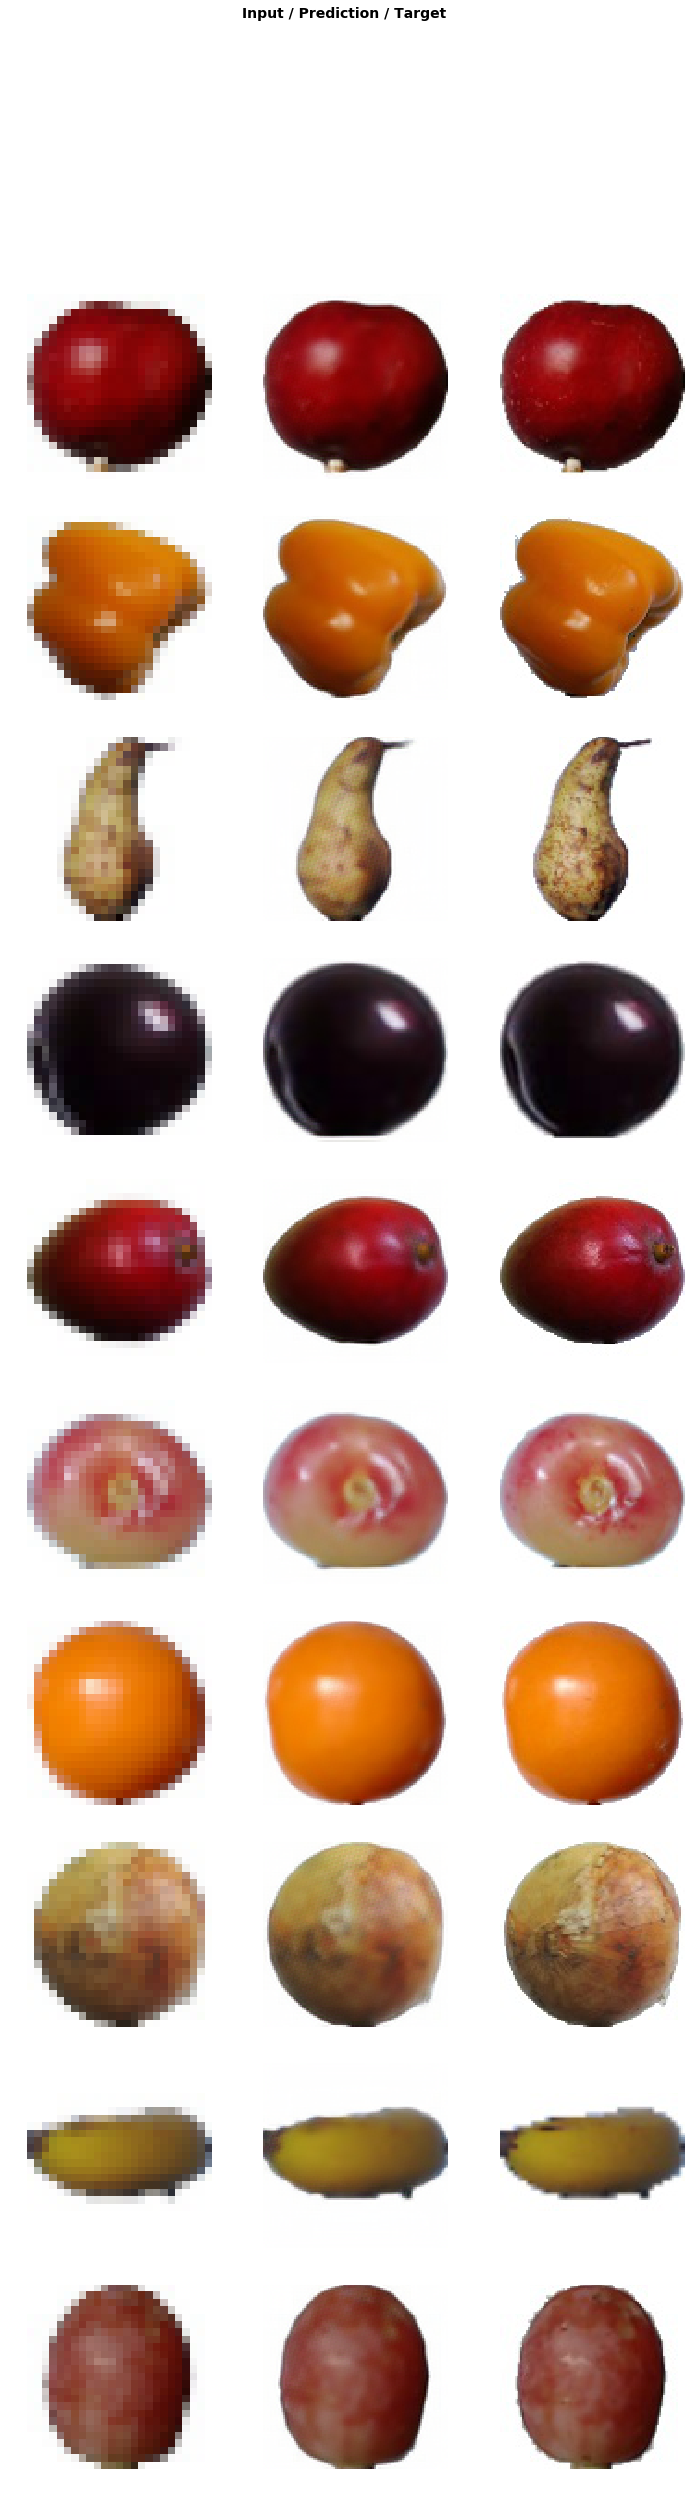

In [35]:
learn.show_results(rows=10)